# **Ingénierie de données + Régression linéaire (Musées & population)**

Notre objectif est de construire un petit pipeline en Python pour récupérer automatiquement la liste des musées les plus visités (depuis Wikipédia), l'enrichir avec la population des villes (via le dataset depuis Kaggle), puis étudier la relation entre la population d'une ville et la fréquentation de ses musées à l'aide d'un modèle simple de régression linéaire.
Enfin, nous visualiserons le résultat de la régression pour interpréter la tendance.

## **Sommaire**

- **Récupération du tableau Wikipédia (scraping)**

- **Chargement et exploration du dataset des villes (population)**

- **Nettoyage et normalisation des données (noms de villes, formats numériques)**

- **Simulation jointure musées ↔ villes (population)** 

- **Jointure musées ↔ villes (population)**

- **Analyse exploratoire & visualisations utiles**

- **Entraînement d'un modèle de régression linéaire**

- **Visualisation de la régression (nuage de points + droite)**

- **Conclusion : interprétation, limites et pistes d'amélioration**

## **Installation et importation des librairies**

Avant de commencer, nous devons exécuter la cellule ci-dessous afin de s'assurer que nous avons accès aux librairies nécessaires (scraping, manipulation de données, visualisation et ML).
On privilégie des outils simples, robustes et standard : **pandas** (data), **pandas.read_html** (Wikipédia), **matplotlib** **seaborn** (plots) ,**scikit-learn** (régression) et **sweetviz** (visualisation).



In [557]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sweetviz as sv
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score






## **Récupération du tableau Wikipédia (scraping)**

In [558]:
# Scraping du tableau Wikipédia

url = "data/most-visited-museums.html"
tables = pd.read_html(url) 
df_museum = tables[0] 
print(df_museum.head())




                       Name              Visitors                City  \
0                    Louvre  9,000,000 (2025) [1]               Paris   
1  National Museum of China   6,956,800 (2024)[2]             Beijing   
2           Vatican Museums   6,825,436 (2024)[3]  Vatican City, Rome   
3           Shenzhen Museum   6,805,000 (2024)[4]            Shenzhen   
4            British Museum   6,479,952 (2024)[5]              London   

          Country  
0          France  
1           China  
2         Vatican  
3           China  
4  United Kingdom  


## **Chargement et exploration du dataset des villes (population)**

In [559]:
# Chargement du dataset des villes

df_cities = pd.read_csv("data/world-largest-cities-by-population-2024.csv")

df_cities.head()


,Unnamed: 0,City,Country,Population (2024),Population (2023),Growth Rate
0,0,Tokyo,Japan,37115035,37194105,-0.0021
1,1,Delhi,India,33807403,32941309,0.0263
2,2,Shanghai,China,29867918,29210808,0.0225
3,3,Dhaka,Bangladesh,23935652,23209616,0.0313
4,4,Sao Paulo,Brazil,22806704,22619736,0.0083


In [560]:
df_cities = df_cities.drop(columns=["Unnamed: 0", "Growth Rate"])

df_cities.head()

,City,Country,Population (2024),Population (2023)
0,Tokyo,Japan,37115035,37194105
1,Delhi,India,33807403,32941309
2,Shanghai,China,29867918,29210808
3,Dhaka,Bangladesh,23935652,23209616
4,Sao Paulo,Brazil,22806704,22619736


## **Nettoyage et normalisation des données (noms de villes, formats numériques)**

In [561]:

def extract_year_robust(x, default_year=2024):
    if pd.isna(x):
        return default_year

    s = str(x)

    m = re.search(r"\((\d{4})\)", s)
    if m:
        return int(m.group(1))

    m = re.search(r"\(FY\s*(\d{4})\s*-\s*\d{2}\)", s, re.IGNORECASE)
    if m:
        return int(m.group(1))

    return default_year

df_museum["Year"] = df_museum["Visitors"].apply(extract_year_robust)

In [562]:
#Normalisation de la colonne visitors : df_museum 
df_museum_test = df_museum.copy()
df_museum_test["Visitors"] = (
    df_museum["Visitors"]
    .str.replace(",", "", regex=False)
    .str.extract(r"(\d+)")
    .astype(int)
)
def print_df_info(df, n=5):
    ("====== APERÇU DES DONNÉES ======")

    print("\n--- head() ---")
    print(df.head(n))

    print("\n--- dtypes ---")
    print(df.dtypes)

    print("\n--- valeurs manquantes (isna().sum()) ---")
    print(df.isna().sum())

    print("\n--- describe() ---")
    print(df.describe())
print_df_info(df_museum_test) 


--- head() ---
                       Name  Visitors                City         Country  \
0                    Louvre   9000000               Paris          France   
1  National Museum of China   6956800             Beijing           China   
2           Vatican Museums   6825436  Vatican City, Rome         Vatican   
3           Shenzhen Museum   6805000            Shenzhen           China   
4            British Museum   6479952              London  United Kingdom   

   Year  
0  2025  
1  2024  
2  2024  
3  2024  
4  2024  

--- dtypes ---
Name        object
Visitors     int64
City        object
Country     object
Year         int64
dtype: object

--- valeurs manquantes (isna().sum()) ---
Name        0
Visitors    0
City        0
Country     0
Year        0
dtype: int64

--- describe() ---
           Visitors         Year
count  6.300000e+01    63.000000
mean   2.846943e+06  2023.873016
std    1.918684e+06     0.420908
min    2.000000e+00  2022.000000
25%    1.659100e+06  2024


--- head() ---
                       Name  Visitors                City         Country  \
0                    Louvre   9000000               Paris          France   
1  National Museum of China   6956800             Beijing           China   
2           Vatican Museums   6825436  Vatican City, Rome         Vatican   
3           Shenzhen Museum   6805000            Shenzhen           China   
4            British Museum   6479952              London  United Kingdom   

   Year  
0  2025  
1  2024  
2  2024  
3  2024  
4  2024  

--- dtypes ---
Name        object
Visitors     int64
City        object
Country     object
Year         int64
dtype: object

--- valeurs manquantes (isna().sum()) ---
Name        0
Visitors    0
City        0
Country     0
Year        0
dtype: int64

--- describe() ---
           Visitors         Year
count  6.300000e+01    63.000000
mean   3.137260e+06  2023.873016
std    1.758037e+06     0.420908
min    1.214851e+06  2022.000000
25%    1.797518e+06  2024

                                             |          | [  0%]   00:00 -> (? left)


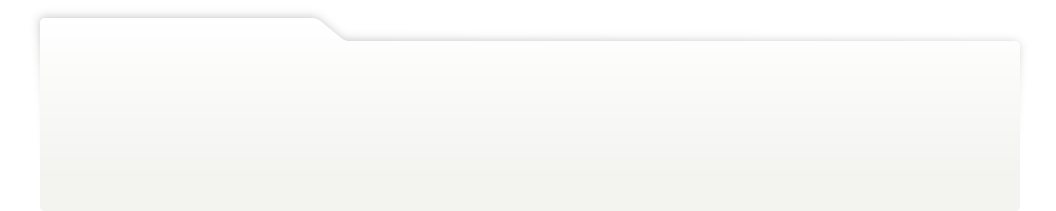
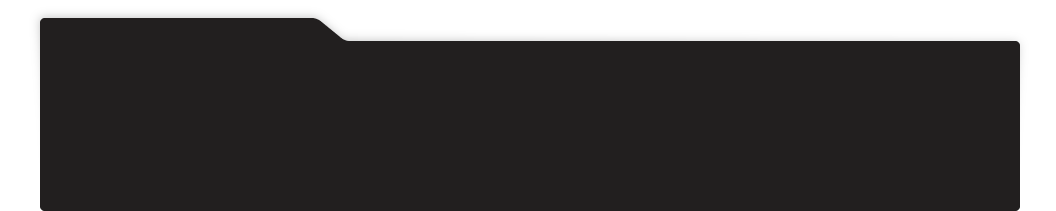
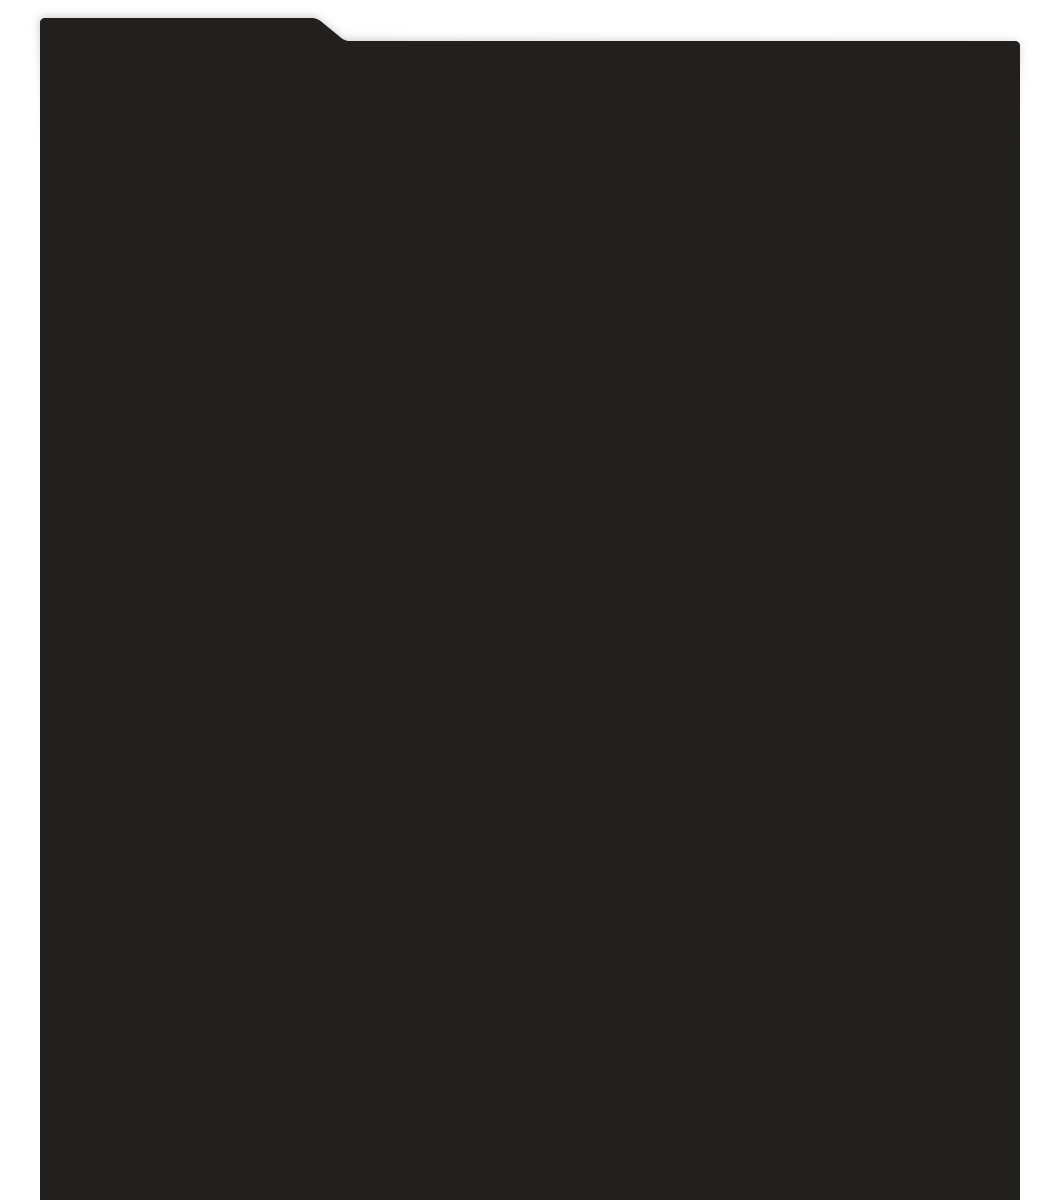
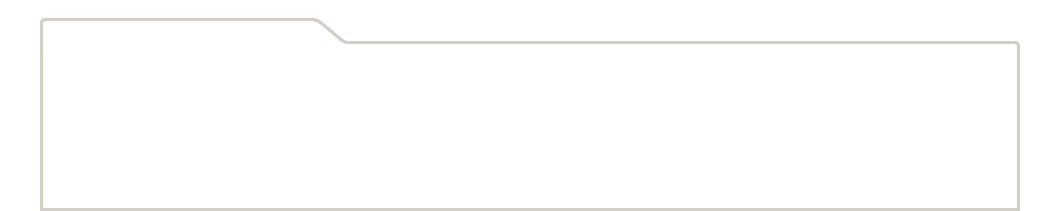
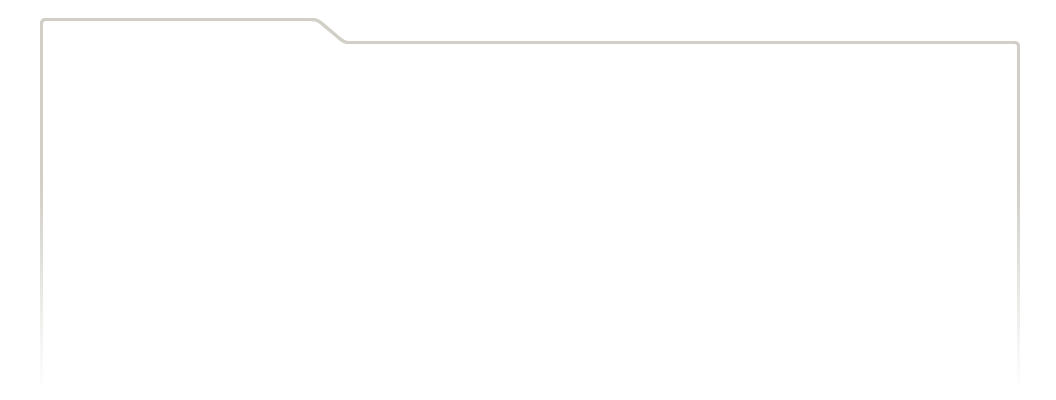
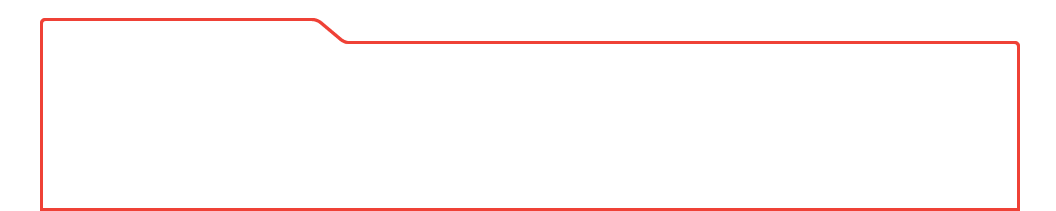
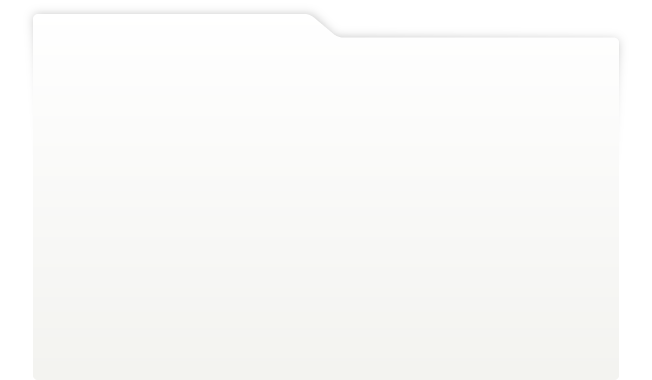
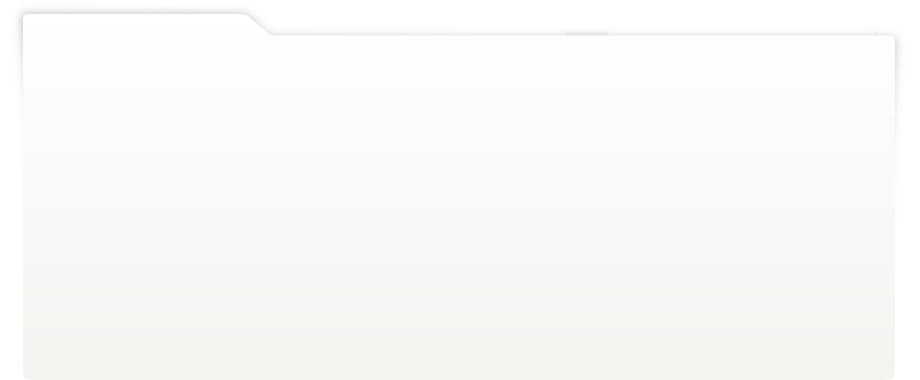
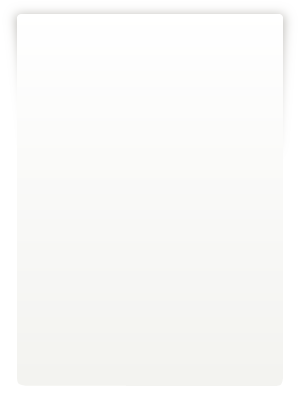
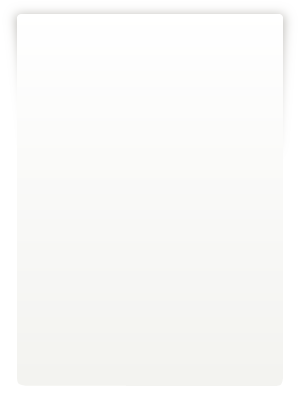
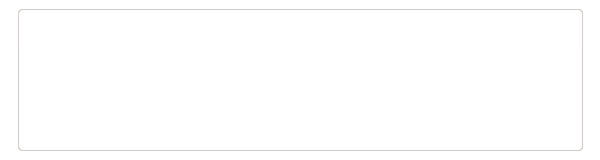
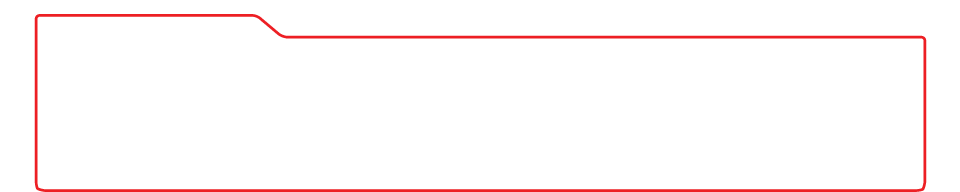
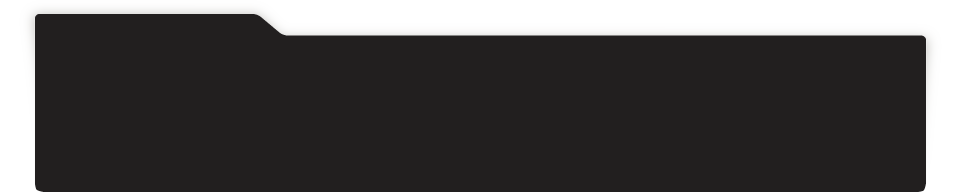
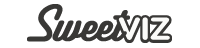
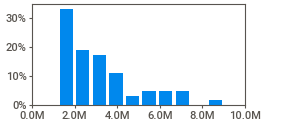
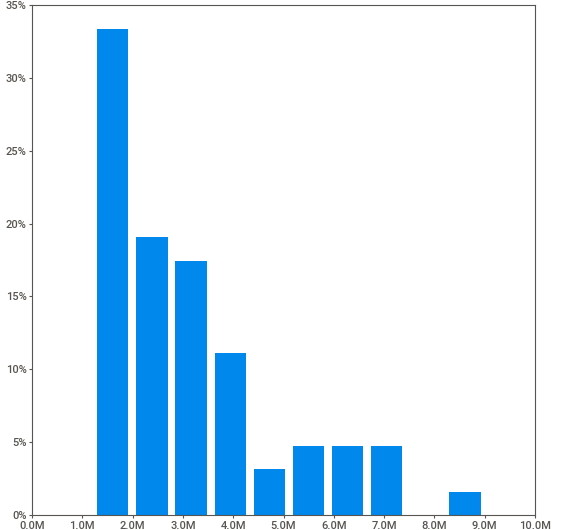
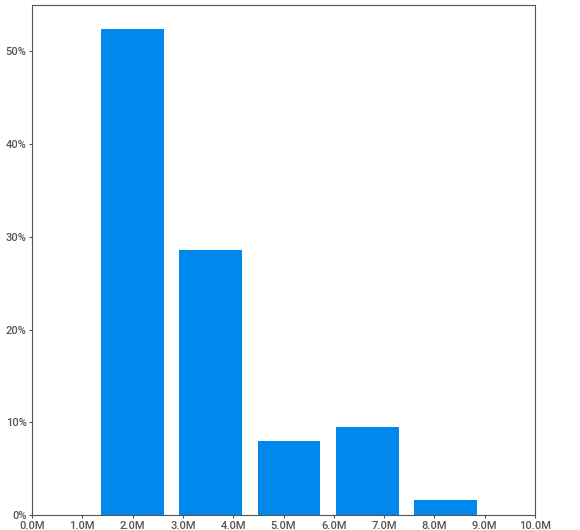
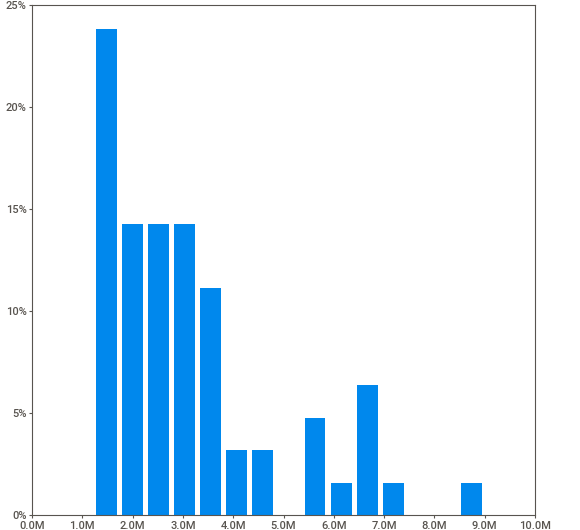
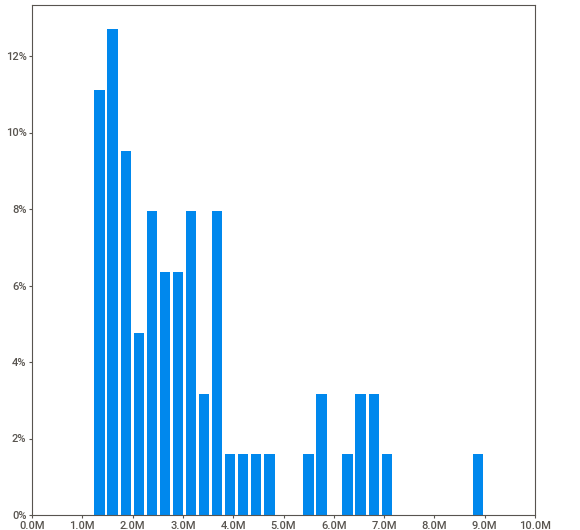
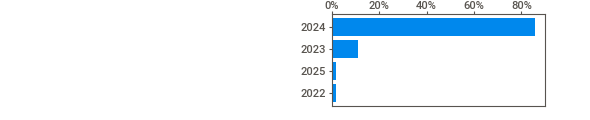
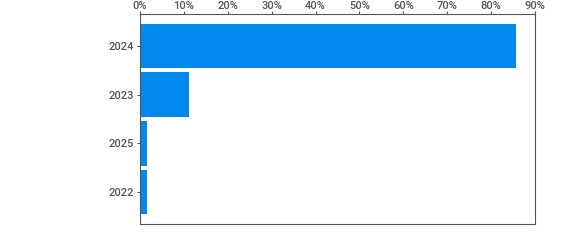
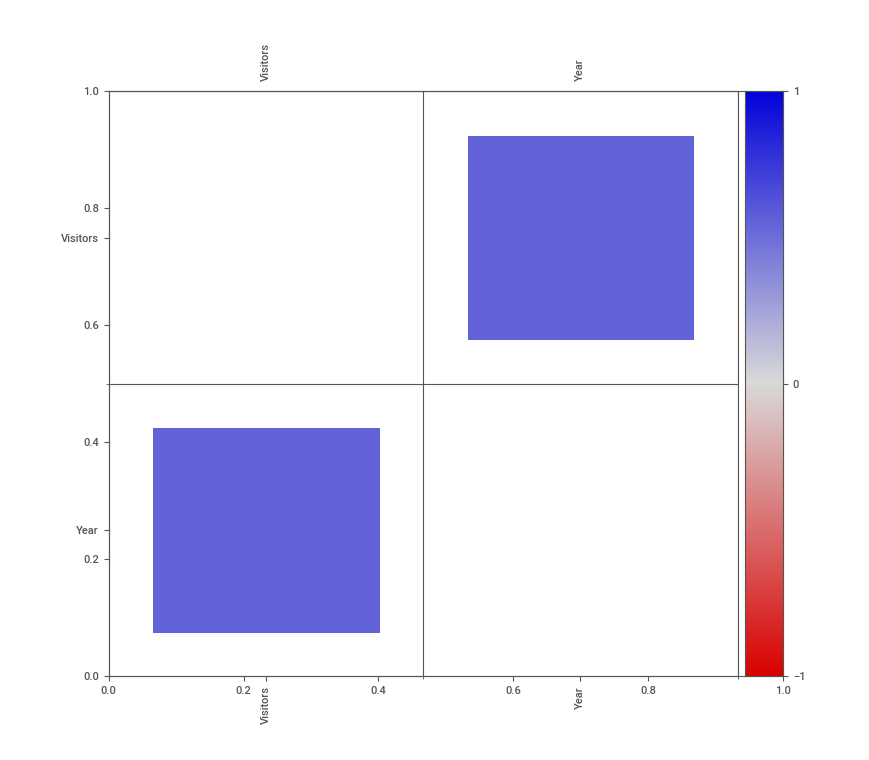
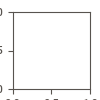

In [563]:
#correction conversion en entier de la colonne "Visitors"  

def parse_int_robust(x):
    if pd.isna(x):
        return None

    s = str(x).lower().strip()
    s = re.sub(r"\[.*?\]", "", s)
    s = re.sub(r"\(.*?\)", "", s)
    s = s.replace(" ", "")

    if re.match(r"^\d{1,3}(,\d{3})+$", s):
        return int(s.replace(",", ""))

    if "million" in s or s.endswith("m"):
        nums = re.findall(r"[\d.]+", s)
        if nums:
            return int(float(nums[0]) * 1_000_000)

    if s.isdigit():
        return int(s)

    return None 
    
def print_report(df):
    report = sv.analyze(df)
    report.show_notebook()



df_museum["Visitors"] = df_museum["Visitors"].apply(parse_int_robust)
print_df_info(df_museum)
print_report(df_museum)



# **Simulation jointure musées ↔ villes (population)**


--- head() ---
                                  Name  Visitors                City  \
0             National Museum of China   6956800             Beijing   
1                      Vatican Museums   6825436  Vatican City, Rome   
2                      Shenzhen Museum   6805000            Shenzhen   
3                       British Museum   6479952              London   
4  China Science and Technology Museum   6421000             Beijing   

          Country  Year  Population (2024)  
0           China  2024         22189082.0  
1         Vatican  2024                NaN  
2           China  2024         13311855.0  
3  United Kingdom  2024          9748033.0  
4           China  2024         22189082.0  

--- dtypes ---
Name                  object
Visitors               int64
City                  object
Country               object
Year                   int64
Population (2024)    float64
dtype: object

--- valeurs manquantes (isna().sum()) ---
Name                  0
Visitors  

                                             |          | [  0%]   00:00 -> (? left)


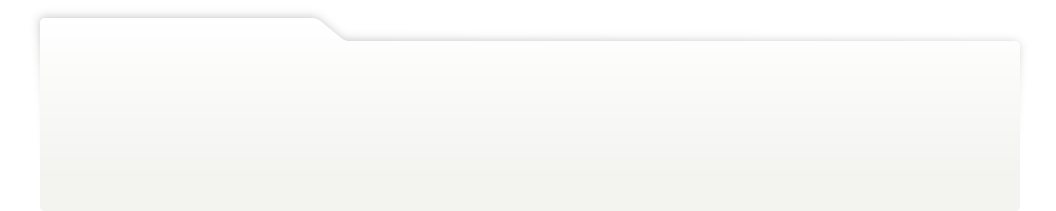
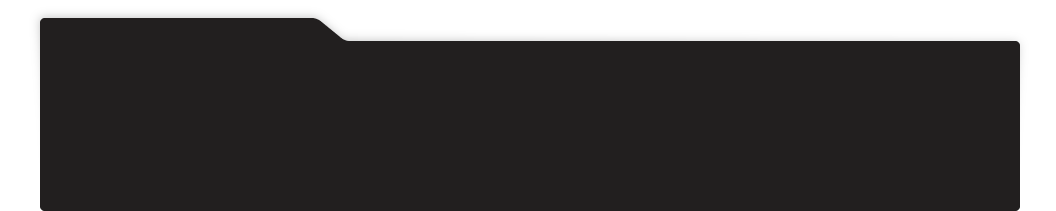
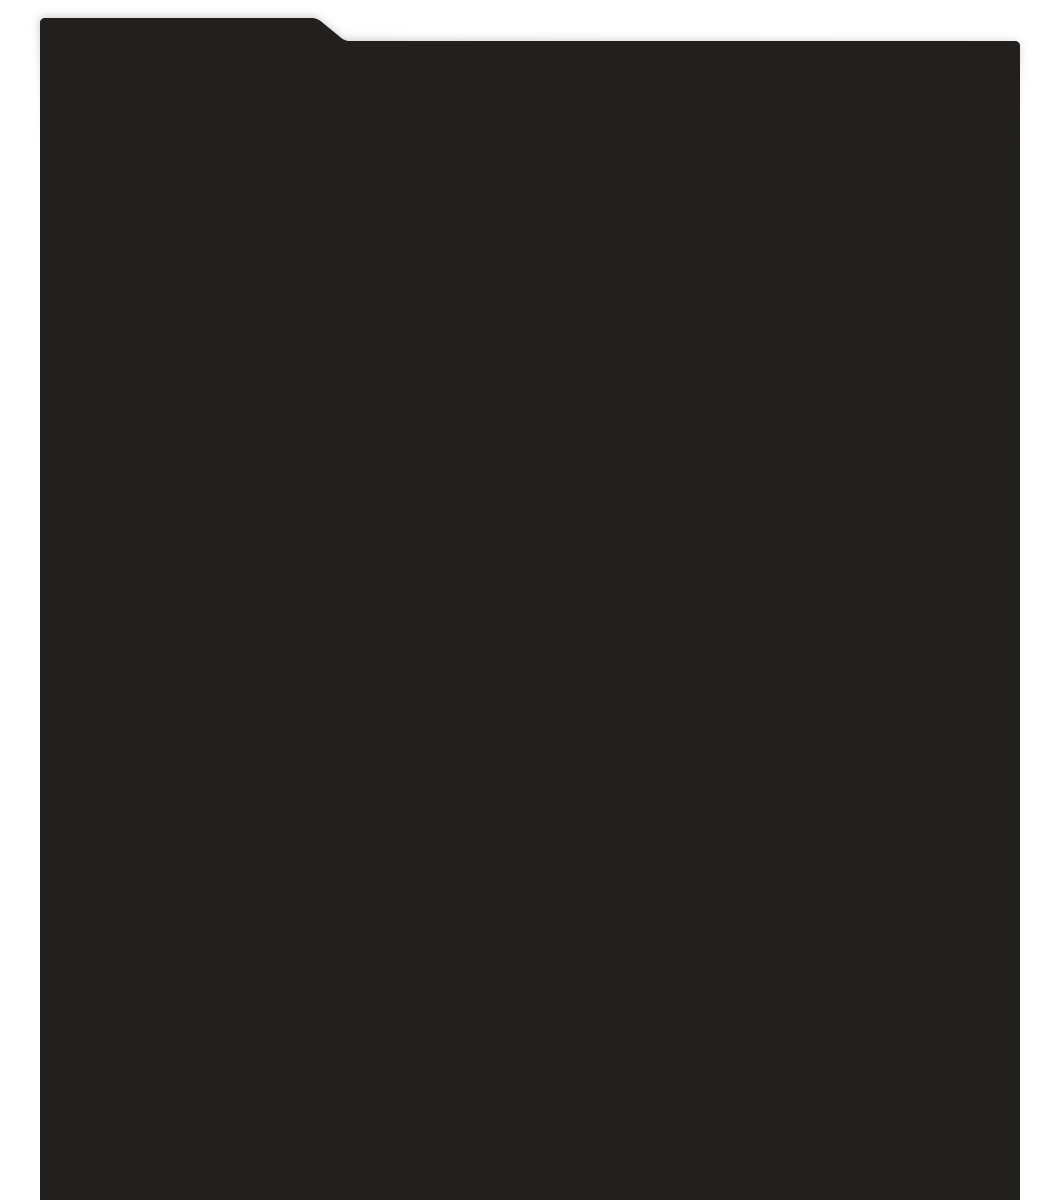
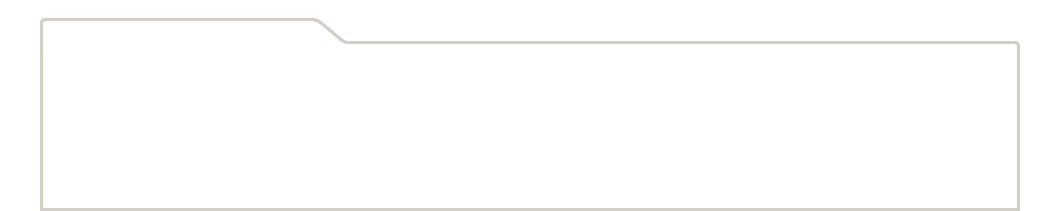
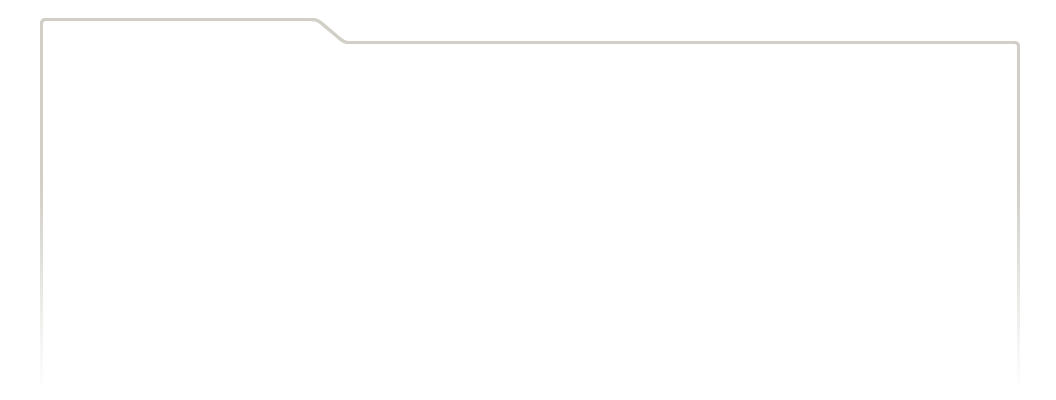
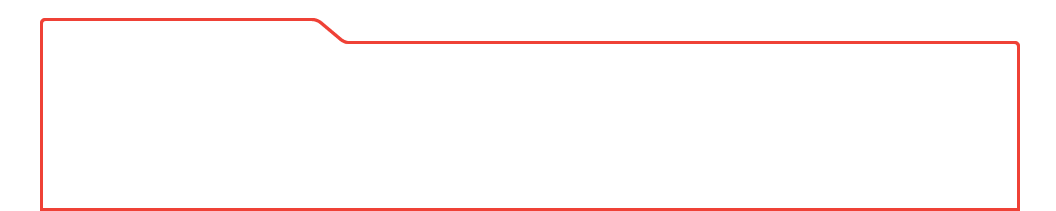
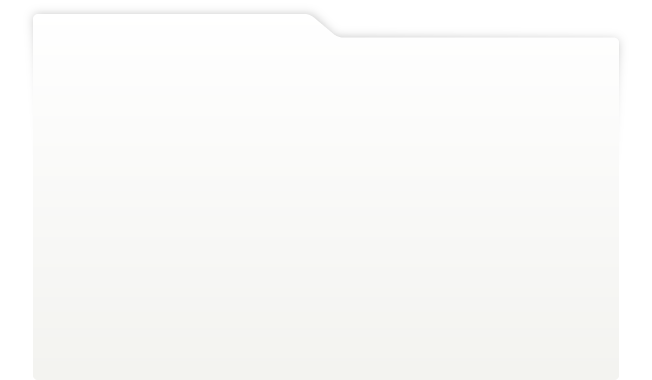
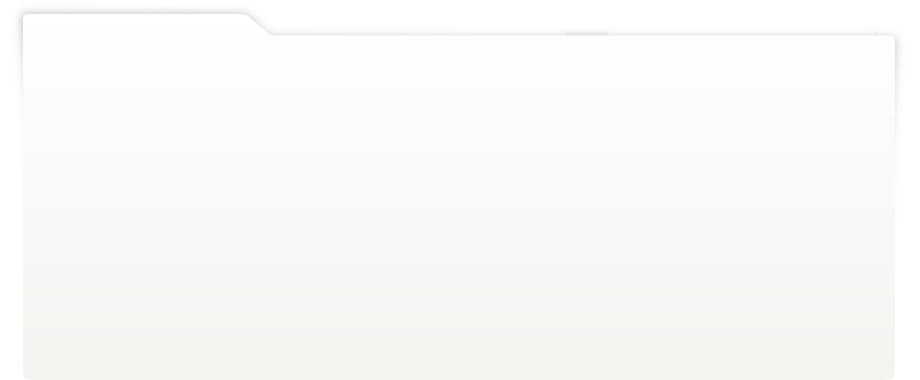
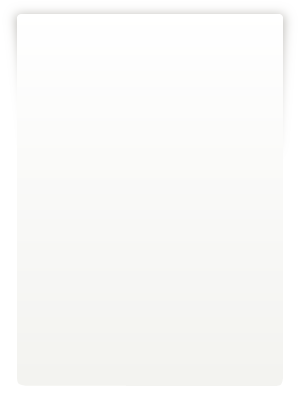
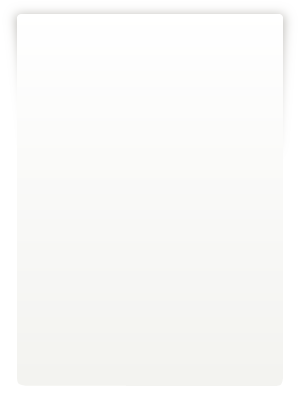
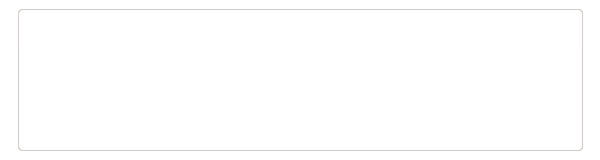
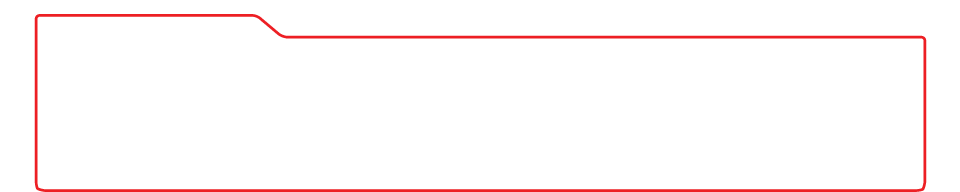
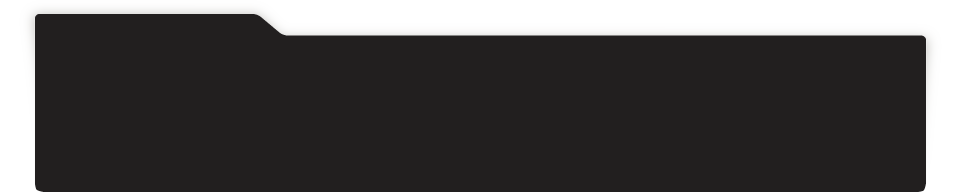
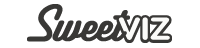
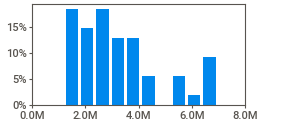
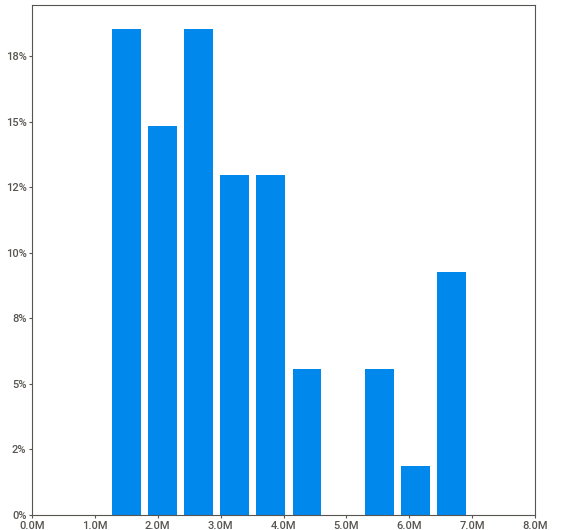
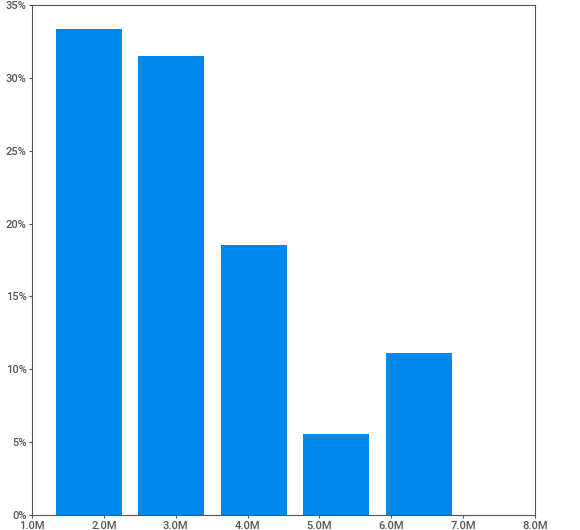
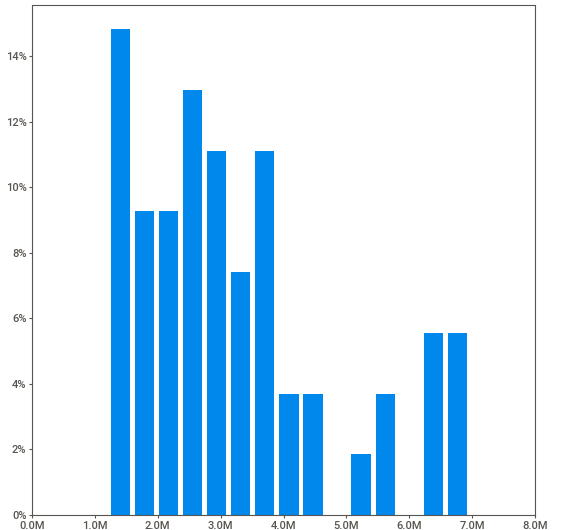
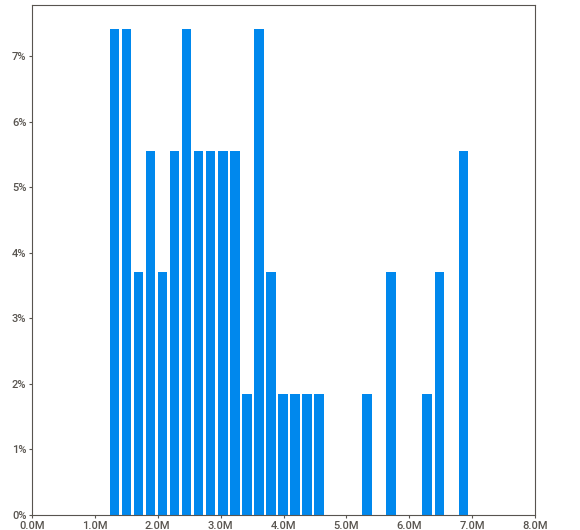
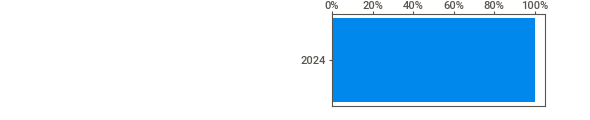
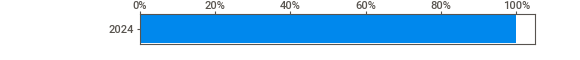
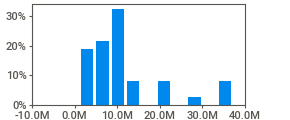
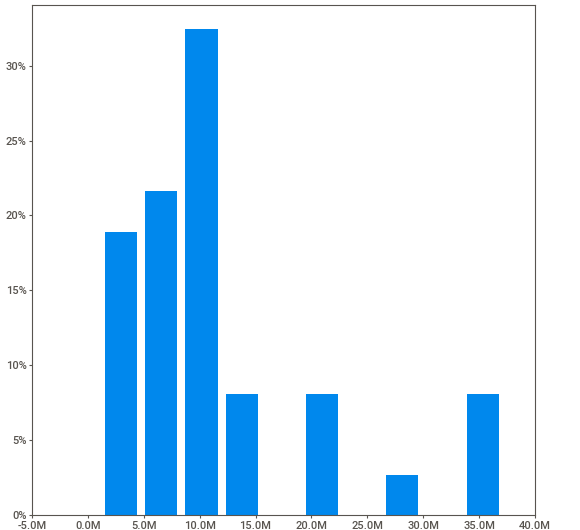
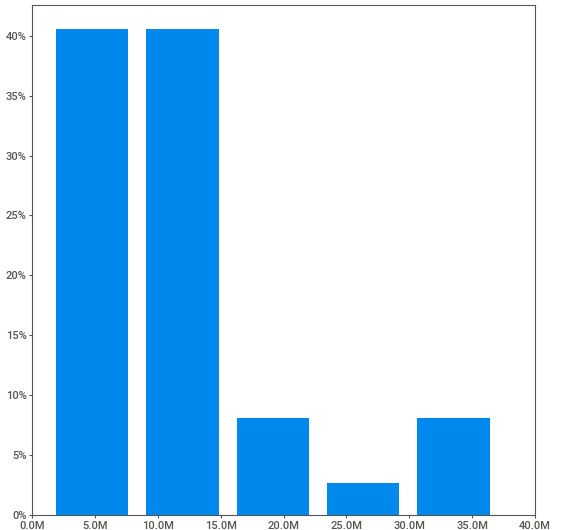
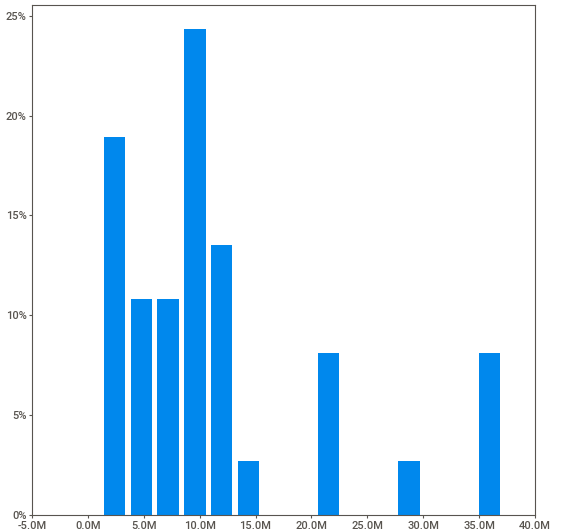
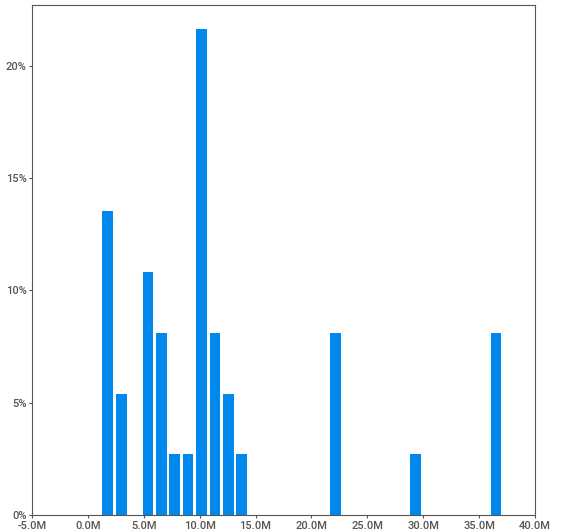
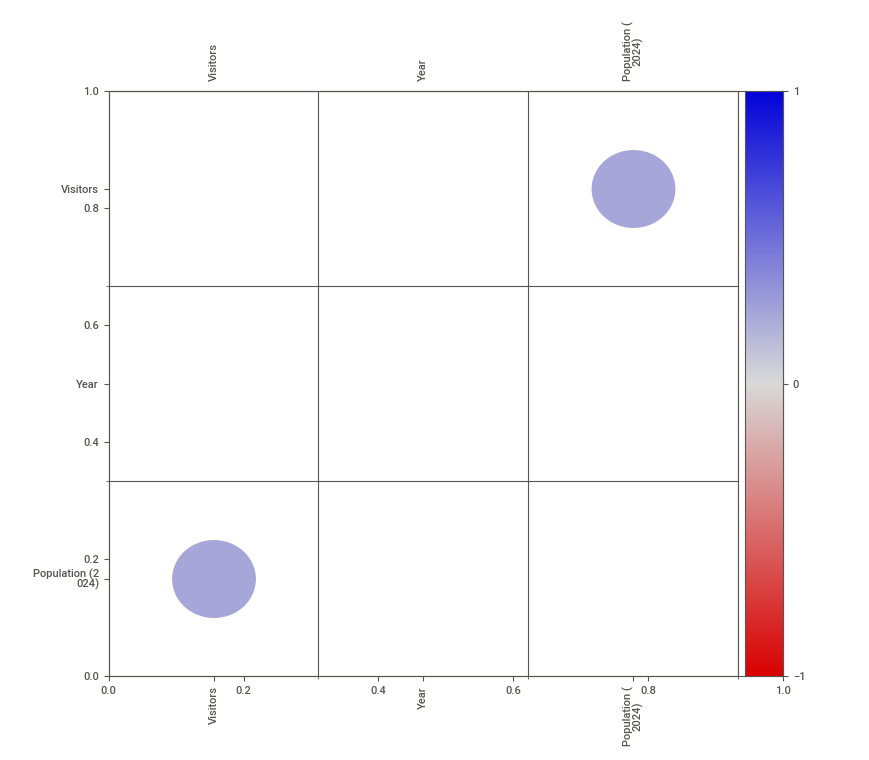
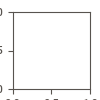

In [564]:

df_museum_2024 = df_museum[df_museum["Year"] == 2024]

df_joined = pd.merge(df_museum_2024, df_cities[["City", "Population (2024)"]], on="City", how="left") 

print_df_info(df_joined) 
print_report(df_joined)

In [565]:
def lignes_manquantes_avec_villes(df, city_col="City", pop_col="Population (2024)"):
    lignes_manquantes = df[df[pop_col].isna()]
    villes = lignes_manquantes[city_col].dropna().astype(str).str.strip().unique()
    return lignes_manquantes, villes

    
lignes_missing, villes_missing = lignes_manquantes_avec_villes(df_joined)

print("Villes avec population manquante :", len(villes_missing))
print(villes_missing)

lignes_missing.head()


Villes avec population manquante : 11
['Vatican City, Rome' 'New York City' 'Washington, D.C.'
 'London, South Kensington' 'Florence' 'Taichung' 'Edinburgh' 'Kraków'
 'Kaohsiung' 'São Paulo' 'Bilbao']


,Name,Visitors,City,Country,Year,Population (2024)
1,Vatican Museums,6825436,"Vatican City, Rome",Vatican,2024,NaN
6,Metropolitan Museum of Art,5700000,New York City,United States,2024,NaN
8,American Museum of Natural History,5400000,New York City,United States,2024,NaN
12,National Gallery of Art,3936543,"Washington, D.C.",United States,2024,NaN
18,Victoria and Albert Museum,3525700,"London, South Kensington",United Kingdom,2024,NaN


In [566]:
#normalisation nom des villes : df_museum et rajout manuelle des villes manquantes 


df_museum["City"] = df_museum["City"].str.strip().str.lower()
df_cities["City"] = df_cities["City"].str.strip().str.lower()
ALIASES = {
    "london, south kensington": "london",
    "new york city": "new york",
    "washington, d.c.": "washington",
    "vatican city, rome": "rome"
} 
MANUAL_INSERT = {
    ("taichung", "taiwan"): 2867848,
    ("florence", "italy"): 382258,
    ("edinburgh", "united kingdom"): 537120,
    ("washington", "united states"): 6789720
}


def insert_missing_cities(df_cities, manual_insert):
    for (city, country), population in manual_insert.items():
            new_row = {"City": city, "Country": country, "Population (2024)": population}
            df_cities = pd.concat([df_cities, pd.DataFrame([new_row])], ignore_index=True)
    return df_cities

def normalize_city_names(df_museum, aliases):
    df_museum["City"] = df_museum["City"].replace(aliases)
    return df_museum

df_museum = normalize_city_names(df_museum, ALIASES)
df_cities = insert_missing_cities(df_cities, MANUAL_INSERT)

print(df_museum[df_museum["City"].isin(["london", "new york", "washington", "rome"])])
print("------------------------------------------")
print(df_cities[df_cities["City"].isin(["florence", "edinburgh", "taichung", ])])


print("------------------------------------------")
#on garde uniquement les musées avec plus de 2000000 visiteurs 
df_museum = df_museum[df_museum["Visitors"] > 2000000]


    

                                        Name  Visitors        City  \
2                            Vatican Museums   6825436        rome   
4                             British Museum   6479952      london   
6   Natural History Museum, South Kensington   6301972      london   
7                 Metropolitan Museum of Art   5700000    new york   
9         American Museum of Natural History   5400000    new york   
10                               Tate Modern   4603025      london   
13                   National Gallery of Art   3936543  washington   
19                Victoria and Albert Museum   3525700      london   
22                          National Gallery   3203451      london   
24          National Air and Space Museum[a]   3100000  washington   
26        National Museum of Natural History   3000000  washington   
29                     London Science Museum   2827242      london   
30                      Museum of Modern Art   2657377    new york   
38                  

# **Jointure musées ↔ villes (population) en 2024**


--- head() ---
                                  Name  Visitors      City         Country  \
0             National Museum of China   6956800   beijing           China   
1                      Vatican Museums   6825436      rome         Vatican   
2                      Shenzhen Museum   6805000  shenzhen           China   
3                       British Museum   6479952    london  United Kingdom   
4  China Science and Technology Museum   6421000   beijing           China   

   Year  Population (2024)  
0  2024           22189082  
1  2024            4331974  
2  2024           13311855  
3  2024            9748033  
4  2024           22189082  

--- dtypes ---
Name                 object
Visitors              int64
City                 object
Country              object
Year                  int64
Population (2024)     int64
dtype: object

--- valeurs manquantes (isna().sum()) ---
Name                 0
Visitors             0
City                 0
Country              0
Year    

                                             |          | [  0%]   00:00 -> (? left)


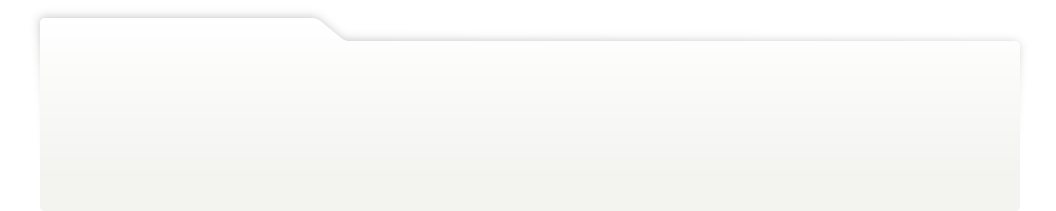
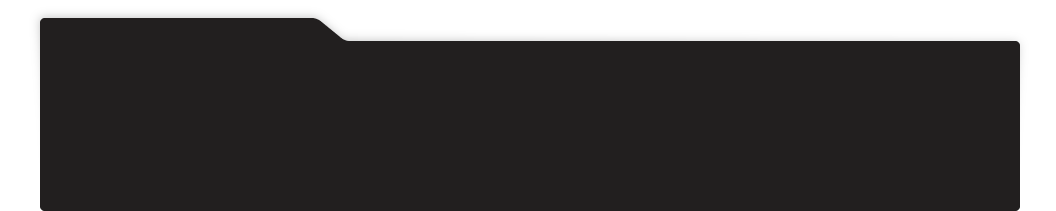
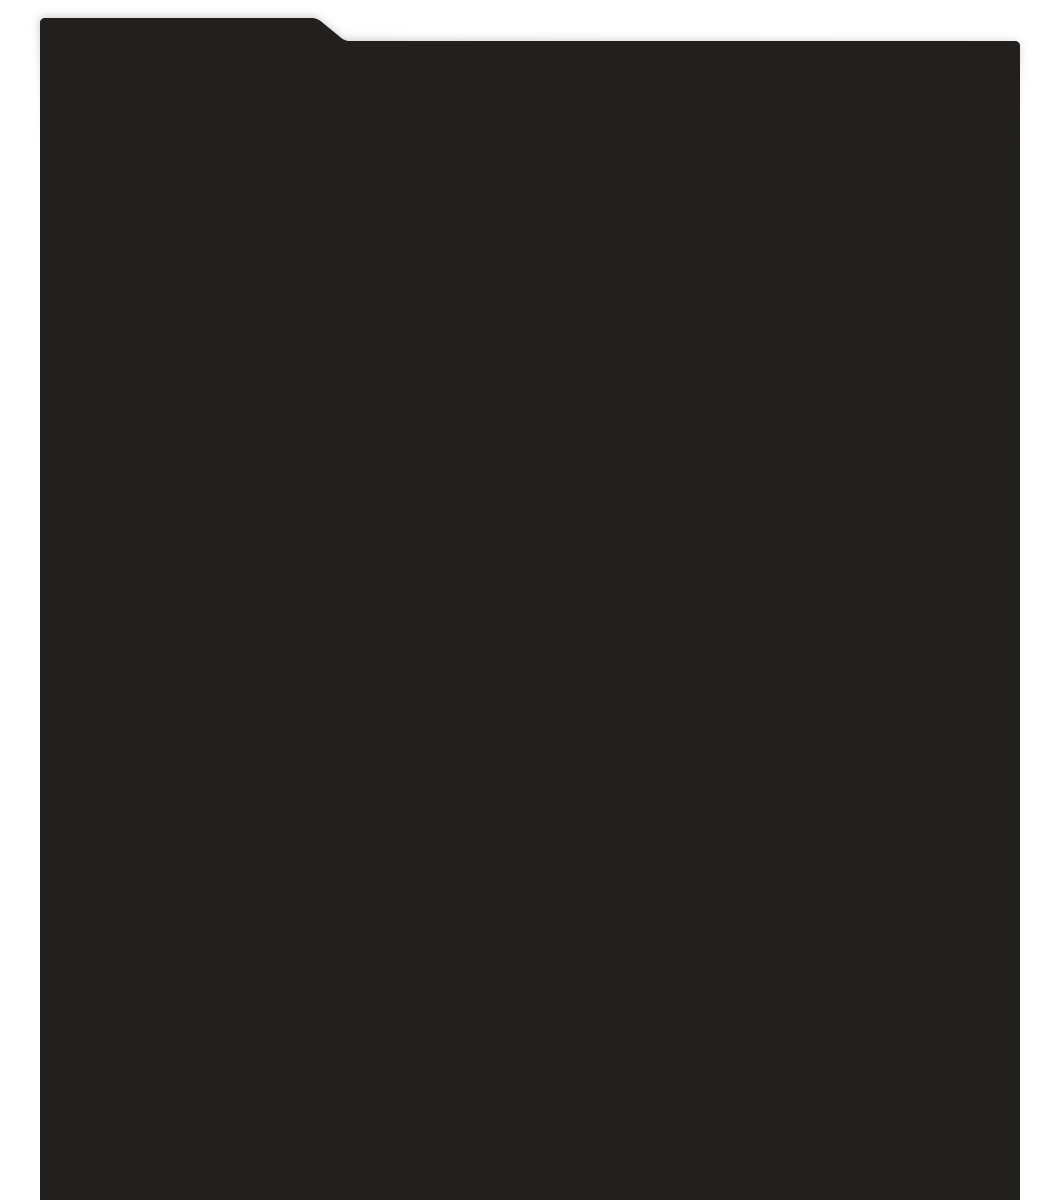
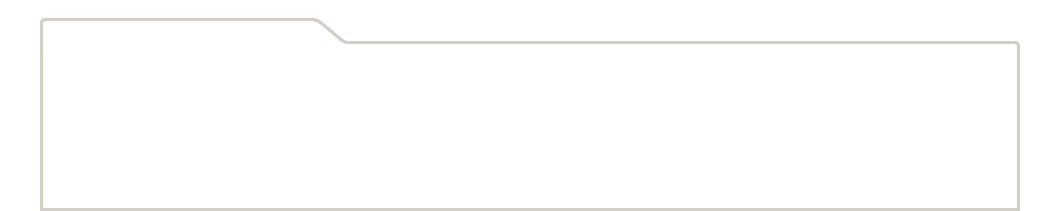
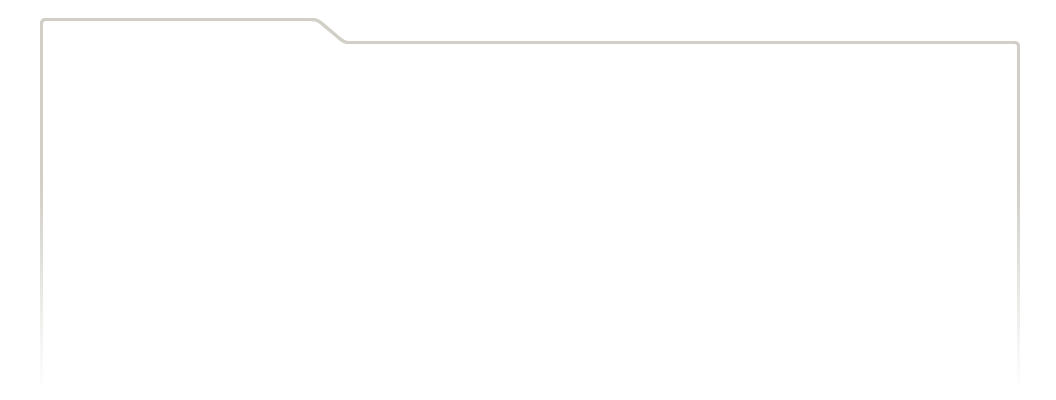
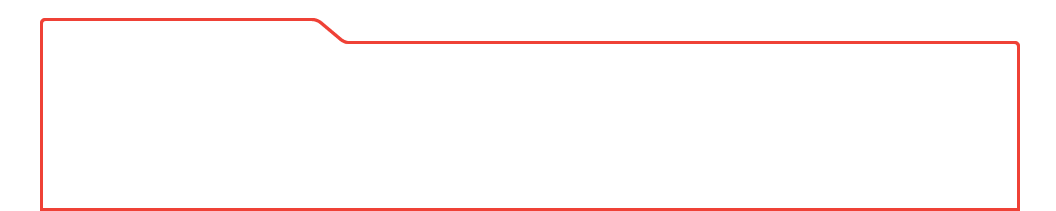
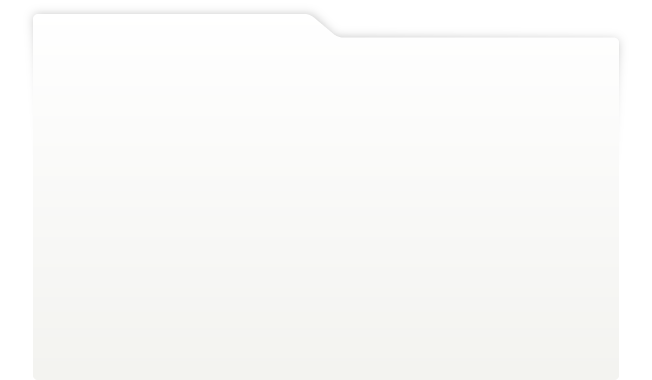
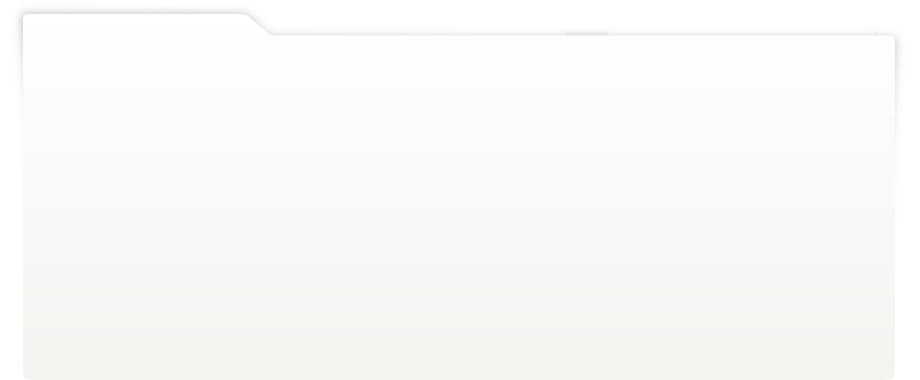
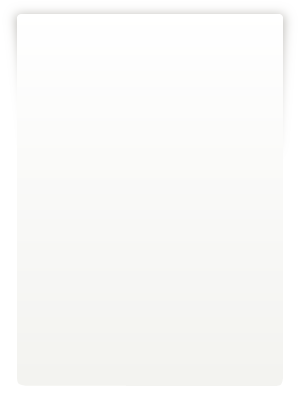
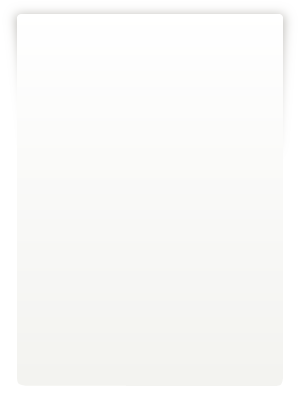
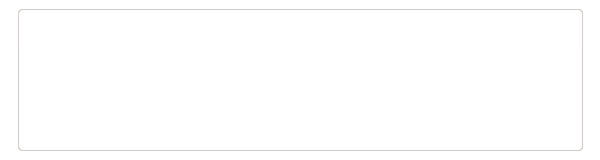
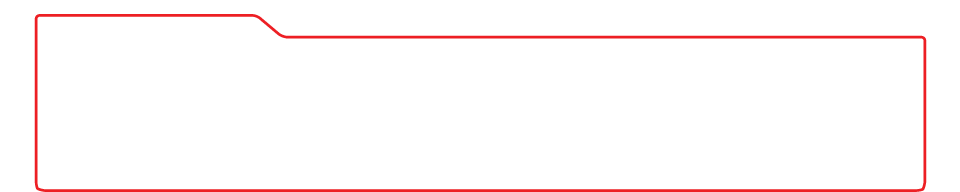
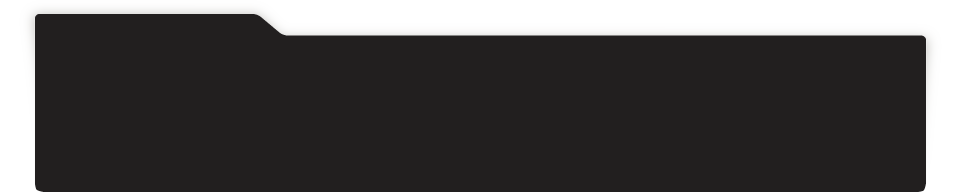
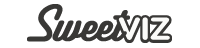
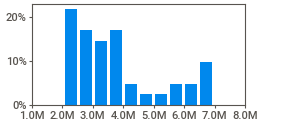
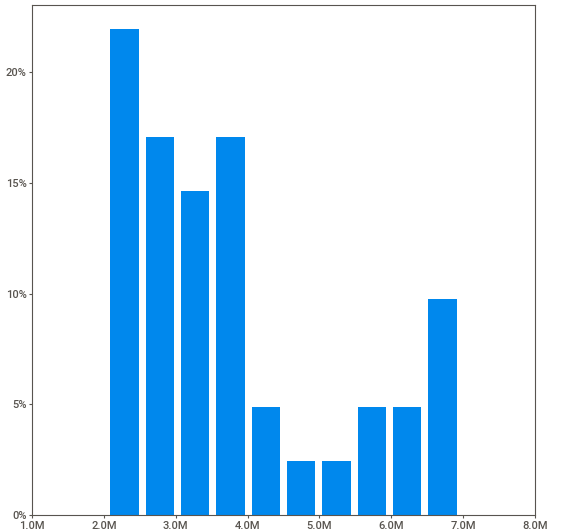
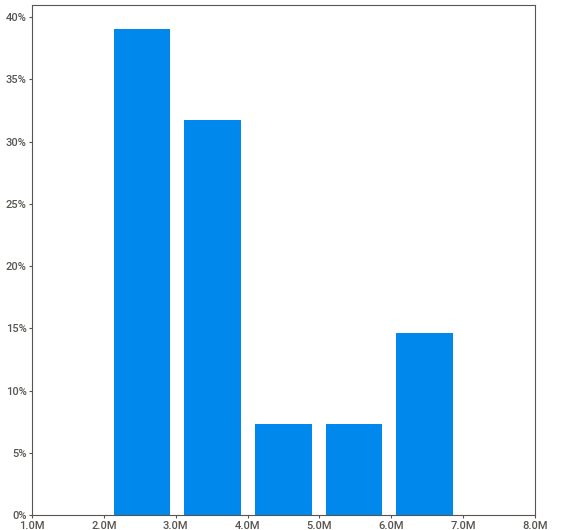
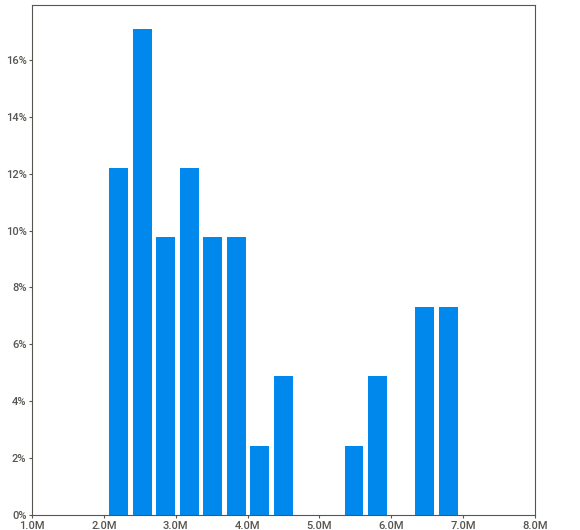
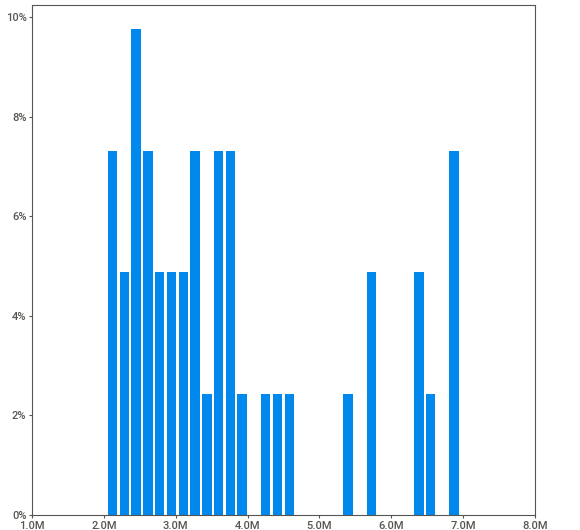
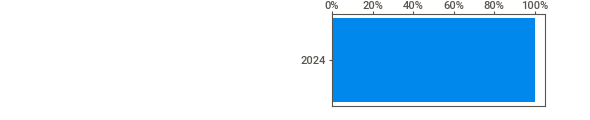
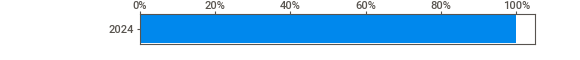
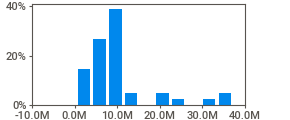
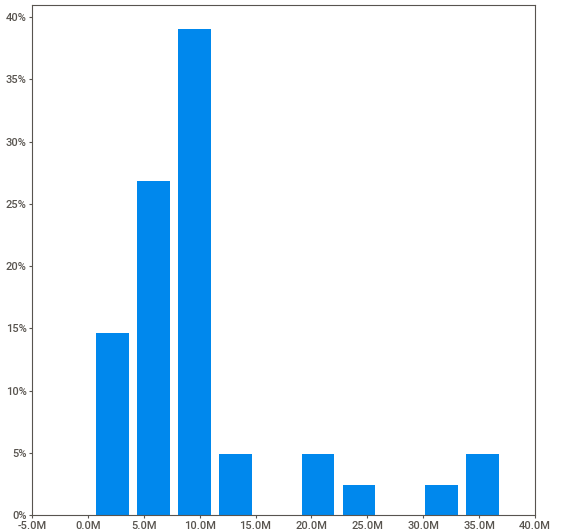
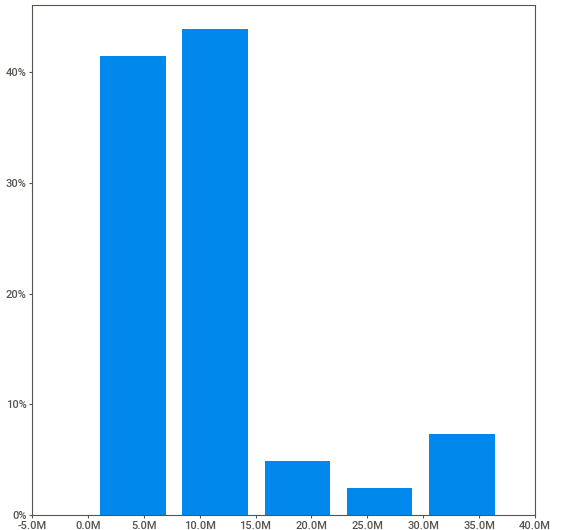
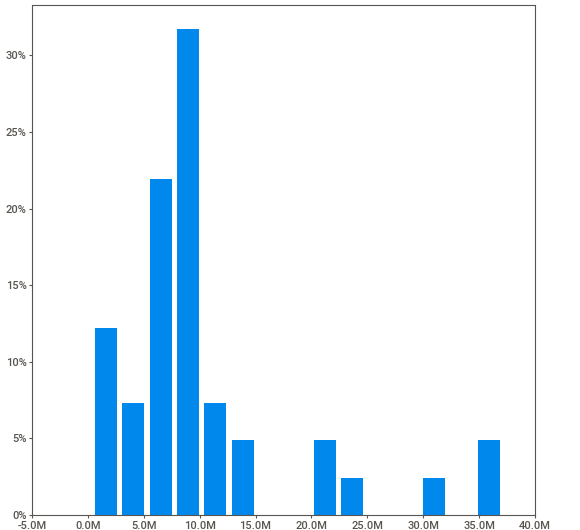
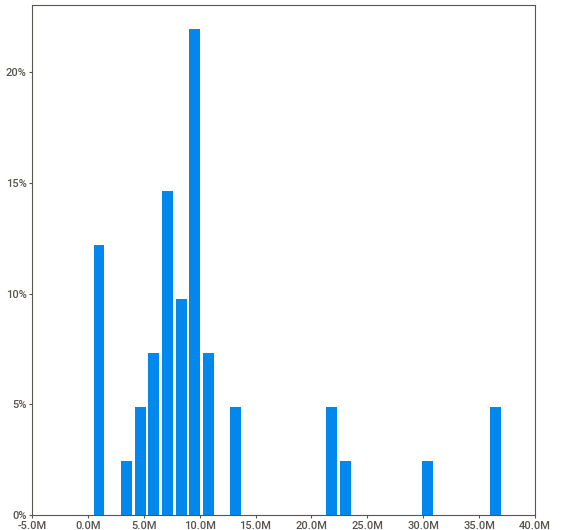
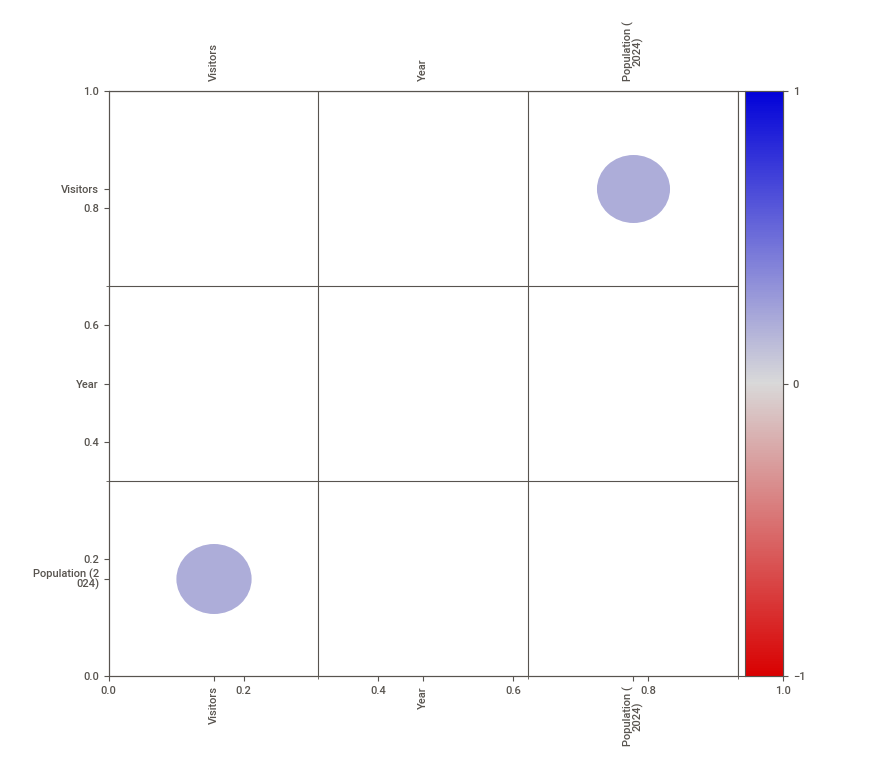
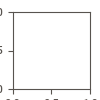

In [567]:
df_museum_2024 = df_museum[df_museum["Year"] == 2024]

df_joined = pd.merge(df_museum_2024, df_cities[["City", "Population (2024)"]], on="City", how="left") 

print_df_info(df_joined) 
print_report(df_joined)


## **Entraînement d'un modèle de régression linéaire**

In [568]:
# Entraînement du modèle
X = df_joined[["Population (2024)"]]
y = df_joined["Visitors"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Coefficient (pente):", model.coef_[0])
print("MSE:", mean_squared_error(y_test, y_pred)) 
print("R²:", r2_score(y_test, y_pred)) #pouvoir expliquer les variations de la variable cible (visitors) par la variable explicative (population) ( le modele explique pas grand chose si R² est proche de 0, explique beaucoup si R² est proche de 1)

Coefficient (pente): 0.010528228404395372
MSE: 1903756075275.3186
R²: 0.018618968959398963


## **Visualisation de la régression (nuage de points + droite)**

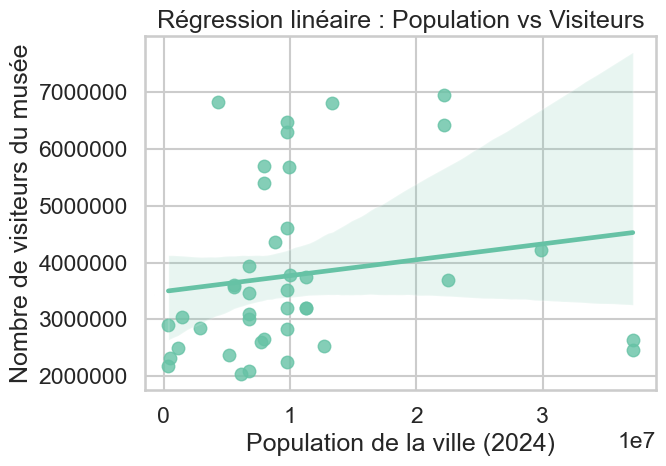

In [569]:
# Visualisation de la régression

sns.set_theme(style="whitegrid", palette="Set2", context="talk")

plt.figure(figsize=(7, 5))
sns.regplot(data=df_joined, x="Population (2024)", y="Visitors", scatter=True)

plt.title("Régression linéaire : Population vs Visiteurs")
plt.xlabel("Population de la ville (2024)")
plt.ylabel("Nombre de visiteurs du musée")
plt.tight_layout()
plt.show()

## **Conclusion : interprétation, limites et pistes d'amélioration**

Le modèle de régression linéaire entraîné pour prédire le nombre de visiteurs à partir de la population de la ville présente une pente faible (coefficient ≈ **0.01**), indiquant que l'augmentation de la population a un effet limité sur la fréquentation des musées.
Le score R² ≈ **0.018** montre que la population n'explique qu'une faible proportion de la variance du nombre de visiteurs.
De plus, l'erreur quadratique moyenne (MSE ≈ **1.9 × 10¹²**) reste élevée, ce qui confirme que le modèle est peu précis pour la prédiction.
Ces résultats confirment que la taille de la ville, prise seule, est un mauvais prédicteur de l’affluence des musées.


D'autres indicateurs comme l'ancienneté du musée, sa réputation internationale, la qualité des collections, les événements culturels organisés ou la proximité de sites touristiques majeurs pourraient exercer une influence bien plus significative sur le nombre de visiteurs.